# Exploratory Data Analysis: Spatiotemporal Matrix

This notebook verifies the "Physics" of the constructed spatiotemporal tensor.
We check for:
1. **Linear Growth:** Headways should increase linearly (0, 1, 2...) until a train arrives.
2. **Reset:** Headways should drop to 0 upon train arrival.
3. **Movement:** Trains should appear as diagonal "valleys" of 0s moving across stations over time.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
MATRIX_PATH = "../data/headway_matrix_full.npy"
STATION_PATH = "../data/a_line_station_distances.csv"
SCHEDULE_PATH = "../data/schedule_matrix_full.npy"

# Load Data
print("Loading Data...")
data = np.load(MATRIX_PATH)
schedule = np.load(SCHEDULE_PATH)
station_map = pd.read_csv(STATION_PATH)

print(f"Headway Matrix Shape: {data.shape}")
print(f"Schedule Matrix Shape: {schedule.shape}")
print(f"Stations: {len(station_map)}")


Loading Data...
Headway Matrix Shape: (264211, 156, 2, 1)
Schedule Matrix Shape: (264211, 2, 1)
Stations: 156


## 1. Verify Physics (Sawtooth Wave)
We plot the time series for a single station. It should look like a sawtooth wave.


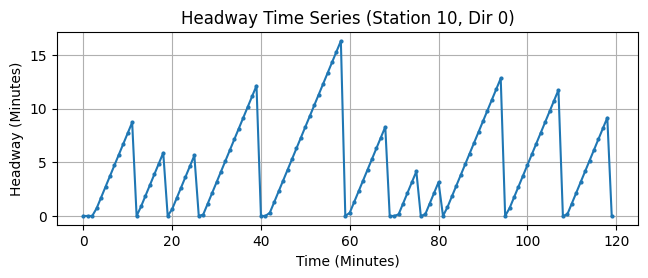

First 20 values (Minutes):
[0.         0.         0.         0.71666667 1.71666667 2.71666667
 3.71666667 4.71666667 5.71666667 6.71666667 7.71666667 8.71666667
 0.         0.88333333 1.88333333 2.88333333 3.88333333 4.88333333
 5.88333333 0.        ]


In [2]:
# Select a station (e.g., index 10) and direction 0 (Northbound)
station_idx = 10
direction_idx = 0
time_steps = 120 # 2 hours

# Extract series
# Shape is (Time, Station, Direction, 1)
# Multiply by 30 to convert back to minutes (Normalization factor from Notebook 3)
series = data[:time_steps, station_idx, direction_idx, 0] * 30

# Plot
plt.figure(figsize=(7.5, 2.5))
plt.plot(series, marker='o', markersize=2)
plt.title(f"Headway Time Series (Station {station_idx}, Dir {direction_idx})")
plt.xlabel("Time (Minutes)")
plt.ylabel("Headway (Minutes)")
plt.grid(True)
plt.show()

# Check values
print("First 20 values (Minutes):")
print(series[:20])


## 2. Verify Train Movement (Space-Time Heatmap)
We plot a heatmap where X=Station, Y=Time.
Trains should appear as dark lines (low headway) moving across stations.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.dates as mdates

def plot_enhanced_micrograph(df, direction_id, sigma=0.8):
    """
    Generates a publication-quality Space-Time diagram.
    
    Args:
        sigma: Amount of smoothing (0.5 to 1.0 is usually best).
    """
    # 1. Filter & Pivot
    subset = df[df['direction'] == direction_id]
    matrix = subset.pivot(index='spatial_order', columns='datetime', values='headway')
    
    # 2. Convert to Numpy for Image Processing
    data = matrix.values
    
    # 3. VISUAL UPGRADE: Gaussian Smoothing
    # This blends the pixelated 1-min bins into smooth 'waves'
    data_smooth = gaussian_filter(data, sigma=sigma)
    
    # 4. VISUAL UPGRADE: Robust Contrast
    # We clip the colors to the 5th and 95th percentiles.
    # This ensures a single massive delay doesn't make the rest of the plot invisible.
    vmin = np.nanpercentile(data, 5)
    vmax = np.nanpercentile(data, 95)
    
    # 5. Setup Plot
    fig, ax = plt.subplots(figsize=(18, 8))
    
    # 6. Render
    # 'inferno' or 'magma' are great for showing "intensity" (dark background)
    im = ax.imshow(
        data_smooth, 
        aspect='auto', 
        origin='lower', 
        
        # --- PICK YOUR FLAVOR HERE ---
        cmap='RdYlGn_r',  # TRAFFIC LIGHT: Green=Fast, Red=Slow (Intuitive)
        # cmap='turbo',   # PHYSICS: Blue=Fast, Red=Slow (Like the Abstract)
        # cmap='inferno', # SONAR: Black=Fast, Yellow=Slow (High Contrast)
        
        vmin=vmin, 
        vmax=vmax,
        interpolation='bicubic' # Makes it look organic/smooth
    )
    
    # 7. Labels
    ax.set_title(f"Space-Time Shockwave Visualization (Dir {direction_id})", fontsize=16, color='#333333')
    ax.set_ylabel("Station Sequence (Direction of Travel ->)", fontsize=12)
    ax.set_xlabel("Time", fontsize=12)
    
    # X-Axis Formatting (Time)
    # Map the column indices back to timestamps for labels
    num_ticks = 10
    time_indices = list(range(0, matrix.shape[1], matrix.shape[1] // num_ticks))
    time_labels = [matrix.columns[i].strftime('%H:%M') for i in time_indices]
    
    ax.set_xticks(time_indices)
    ax.set_xticklabels(time_labels, rotation=45)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, pad=0.01)
    cbar.set_label('Headway Intensity (Smoothed)', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

Plotting Enhanced Micrograph for 2025-06-06 10:00:00 to 2025-06-06 13:59:00...


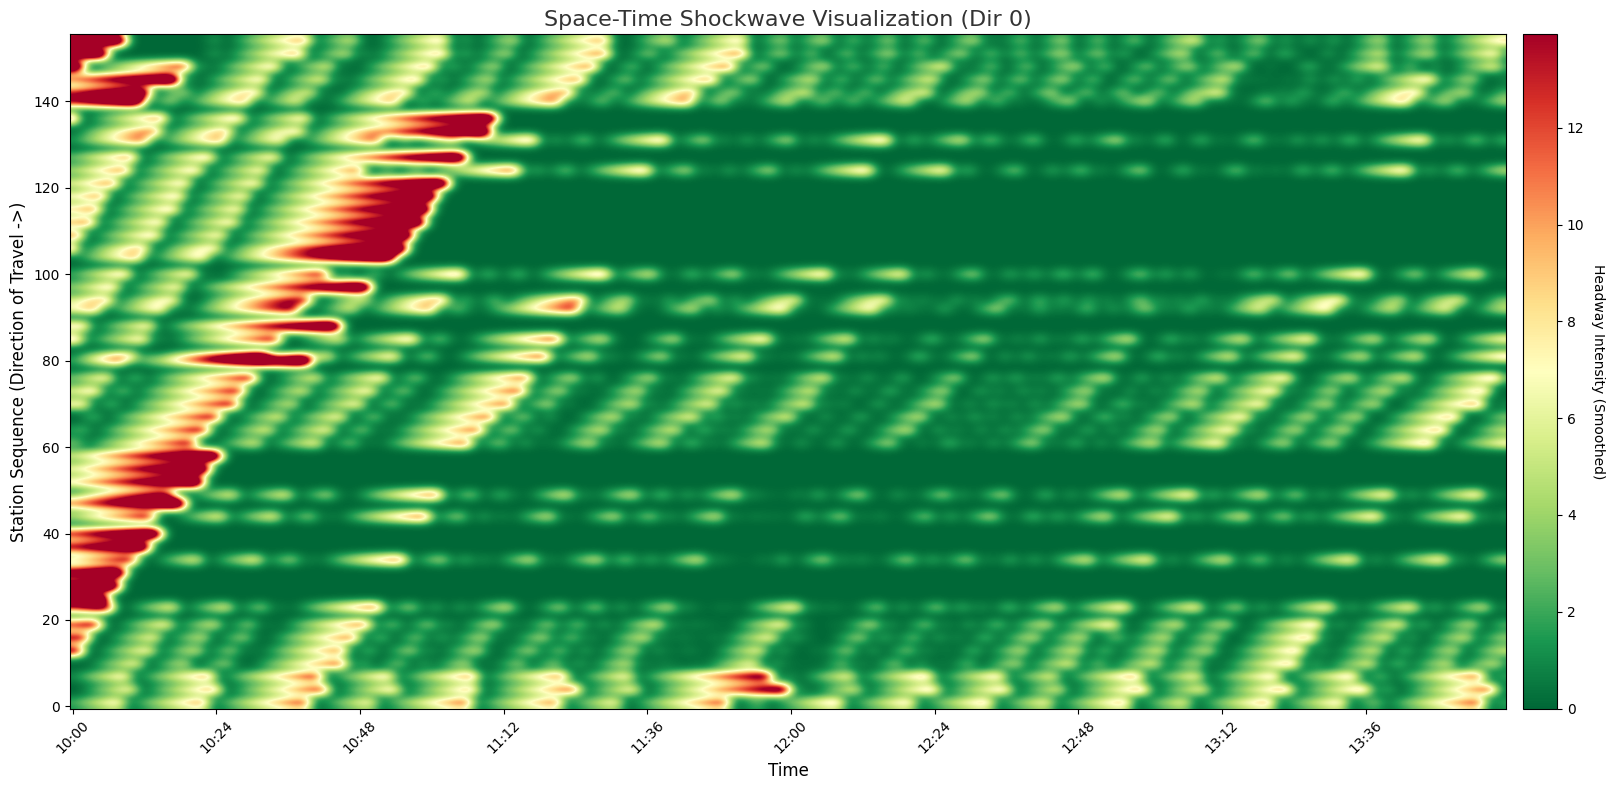

In [4]:
# Prepare data for the Micrograph
# We need to convert a slice of our numpy array back to the DataFrame format expected by the function.

# Configuration
start_idx = 600 # Start at 600 minutes (10:00 AM)
duration_mins = 240 # 4 hours
end_idx = start_idx + duration_mins
direction_to_plot = 0 # Northbound

# 1. Generate Timestamps
# Assuming the data starts at 00:00 on 2025-06-06
start_time = pd.Timestamp("2025-06-06 00:00:00") + pd.Timedelta(minutes=start_idx)
timestamps = pd.date_range(start=start_time, periods=duration_mins, freq="1min")

# 2. Extract Data Slice
# Shape: (Time, Station)
# Multiply by 60 to denormalize (assuming max was 1 hour or 3600s)
# Note: In Notebook 3 we normalized by 3600s (60 mins). 
# If the data is [0,1], multiplying by 60 gives minutes.
subset_data = data[start_idx:end_idx, :, direction_to_plot, 0] * 60.0 

# 3. Vectorized DataFrame Construction
T, S = subset_data.shape
times_flat = np.repeat(timestamps, S)
stations_flat = np.tile(np.arange(S), T)
values_flat = subset_data.flatten()

df_vis = pd.DataFrame({
    'datetime': times_flat,
    'spatial_order': stations_flat,
    'headway': values_flat,
    'direction': direction_to_plot
})

# 4. Plot
print(f"Plotting Enhanced Micrograph for {start_time} to {timestamps[-1]}...")
plot_enhanced_micrograph(df_vis, direction_id=direction_to_plot, sigma=1.0)

## 3. Visualize Input (X) vs Target (Y) Sample
Here we visualize a single training sample to illustrate the prediction task.
*   **Input X (Left):** The past 30 minutes of headway evolution.
*   **Target Y (Right):** The future 15 minutes we want to predict.
The model must learn to extrapolate the "lines" (train trajectories) from the left into the right.

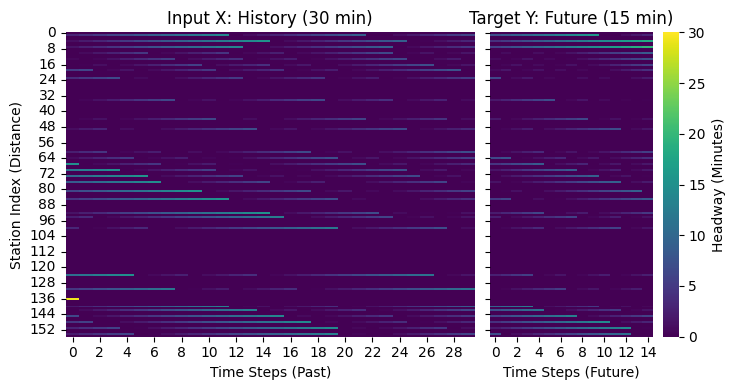

In [5]:
# Configuration
LOOKBACK = 30
FORECAST = 15
current_t = 700 # Arbitrary split point (e.g., 11:40 AM)
direction_idx = 0

# Extract X (History) and Y (Future)
# Transpose for (Space, Time) visualization
# Multiply by 30 to convert to minutes
X_sample = data[current_t-LOOKBACK:current_t, :, direction_idx, 0].T * 30
Y_sample = data[current_t:current_t+FORECAST, :, direction_idx, 0].T * 30

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 4), sharey=True, gridspec_kw={'width_ratios': [2, 1]})

# Plot X (History)
sns.heatmap(X_sample, ax=ax1, cmap="viridis", cbar=False, vmin=0, vmax=30)
ax1.set_title(f"Input X: History ({LOOKBACK} min)")
ax1.set_xlabel("Time Steps (Past)")
ax1.set_ylabel("Station Index (Distance)")
ax1.invert_yaxis() # Optional: match standard map orientation if needed, but usually index 0 is top or bottom depending on preference. 
# Let's keep default heatmap orientation (0 at top)

# Plot Y (Future)
sns.heatmap(Y_sample, ax=ax2, cmap="viridis", cbar_kws={'label': 'Headway (Minutes)'}, vmin=0, vmax=30)
ax2.set_title(f"Target Y: Future ({FORECAST} min)")
ax2.set_xlabel("Time Steps (Future)")

plt.tight_layout()
plt.show()
